# Ordinary Kriging

In [1]:
import pandas as PD
import geopandas as GPD
import numpy as NP
import matplotlib.pyplot as PLT
import scipy.linalg
import rasterio as RAST
from rasterio.transform import from_origin
from scipy import optimize as OPT
from tqdm import tqdm as TQDM
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.optimize import least_squares
from shapely.geometry import Point
from variogram import variogram as VARIOGRAM

In [2]:
class kriging_ordinary(object):

    def __init__(self, varigoram, debug=False):
        ## Local parameters ##
        self.variogram = varigoram
        self.debug = debug

    def fit(self, X, y, to=None, transparent=True, show=False):
        '''
        [DESCRIPTION]
            Store the data with KDTree or original data structure, and fit the variogram model with set parameters. 
        [INPUT]
            X          : array-like, input data with features, same data size with y.
            y          : array-like, input data with interesting value, same data size with X
        [OUTPUT]
            Null
        '''
        X = NP.atleast_1d(X)
        y = NP.atleast_1d(y)
        self.shape = X.shape
        self.ndim = X.ndim
        self.y = y
        self.X = cKDTree(X, copy_data=True)

    def predict(self, X, n_neighbor=None, radius=NP.inf, use_nugget=False, get_error=False):
        '''
        [DESCRIPTION]
           Calculate and predict interesting value with looping for all data, the method take long time but save memory
           Obtain the linear argibra terms
            | V_ij 1 || w_i | = | V_k |
            |  1   0 ||  u  |   |  1  |
                a    *   w    =    b
              w = a^-1 * b
              y = w_i * Y
            V_ij : semi-variance matrix within n neighors
            V_k  : semi-variance vector between interesting point and n neighbors
            w_i  : weights for linear combination
            u    : lagrainge multiplier
            Y    : true value of neighbors
            y    : predicted value of interesting point
        [INPUT]
            X          : array-like, input data with same number of fearture in training data
            n_neighbor : int,        number of neighbor w.r.t input data, while distance < searching radius (5)
            radius     : float,      searching radius w.r.t input data (inf)
            use_nugget : bool,       if use nugget to be diagonal of kriging matrix for prediction calculation (False)
        [OUTPUT]
            1D/2D array(float)
            prediction : float, prdicted value via Kriging system y
            error      : float, error of predicted value (only if get_error = True)
            lambda     : float, lagrange multiplier u
        '''
        X = NP.atleast_1d(X)
        if self.ndim == 1:
            if X.ndim < 2: X = X[:, NP.newaxis]
        else:
            X = NP.atleast_2d(X)     

        ## Find the neighbors 
        if n_neighbor is None: 
            n_neighbor = self.shape[0]
        neighbor_dst, neighbor_idx = self.X.query(X, k=n_neighbor, p=2 )

        ## Calculate prediction
        idxes = range(X.shape[0])
        lambda_y = NP.zeros(len(X))
        predict_y = NP.zeros(len(X))
        error_y = NP.zeros(len(X))
        for nd, ni, i in zip(neighbor_dst, neighbor_idx, idxes):
            ## select in searching radius
            ni = ni[nd < radius] # neighbors' index, while the distance < search radius
            nd = nd[nd < radius] # neighbors' distance, while the distance < search radius
            
            if len(ni) == 0: 
                continue 
            else: 
                n = len(ni)

            ## Initialization
            a = NP.zeros((n+1,n+1))  
            b = NP.ones((n+1,))

            ## Fill matrix a
            a[:n, :n] = self.variogram.predict(cdist(self.X.data[ni], self.X.data[ni], metric='euclidean'))
            a[:n, n] = 1
            a[n, :n] = 1

            ## Fill vector b
            b[:n] = self.variogram.predict(nd)
            #print(b)

            ## set self-varinace is zero if not using Nugget
            if not use_nugget:
                ## modify a
                NP.fill_diagonal(a, 0.)
                ## modify b
                zero_index = NP.where(NP.absolute(nd) == 0)
                if len(zero_index) > 0:
                    b[zero_index[0]] = 0.

            ## Get weights
            #w = scipy.linalg.solve(a, b) # no constraint solution
            w = OPT.nnls(a, b)[0] # non-negative solution

            ## Fill results and prediction
            lambda_y[i] = w[n]
            predict_y[i] = w[:n].dot(self.y[ni])
            error_y[i] = NP.sqrt(w[:n].dot(b[:n]))

        return predict_y, error_y, lambda_y

## Data 1

In [3]:
gdf = GPD.read_file('./data/muese.shp')
gdf.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,x,y,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,181072.0,333611.0,POINT (5.758536241675762 50.99156215667816)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,181025.0,333558.0,POINT (5.757863018200728 50.99108790288359)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,181165.0,333537.0,POINT (5.759855417830628 50.99089274333686)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,181298.0,333484.0,POINT (5.761745770023087 50.99041023559325)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,181307.0,333330.0,POINT (5.761862707698853 50.98902557091748)


In [4]:
NP.random.seed(0)
test_idxes = NP.random.choice(a=gdf.index, size=int(NP.round(len(gdf)/4)))
train_idxes = NP.array(list(set(gdf.index).difference(set(test_idxes))))
meuse_test = gdf.loc[test_idxes,:].copy()
meuse_train = gdf.loc[train_idxes,:].copy()
print(len(meuse_train), len(meuse_test), len(gdf))

122 39 155


<Figure size 720x432 with 0 Axes>

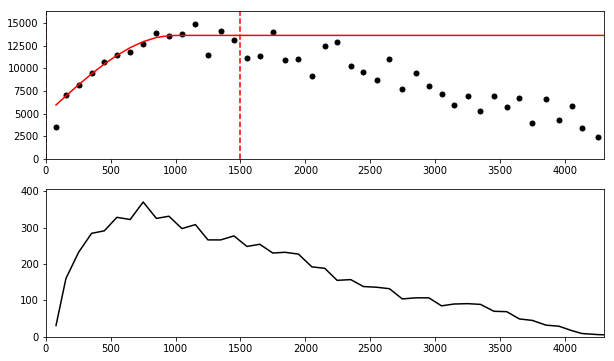

In [5]:
## model
def variogram_spherical(d, pars):
    """Spherical model, pars[3] = [psill, range, nugget]
                             3 * d           d^3  
    x <= [2] : y = [0] * ( ---------  -  ---------- ) + [2]
                            2 * [1]       2 * [1]^3
    x > [2]  : y = [0] + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return NP.piecewise( d, 
                        [d <= prange, d > prange],
                        [lambda x: psill * ((3.*x)/(2.*prange) - (x**3.)/(2.*prange**3.)) + pnugget, 
                         psill + pnugget])
## train variogram
var_muese = VARIOGRAM(100, model=variogram_spherical)
var_muese.fit(meuse_train[['x', 'y']], meuse_train['lead'], fit_range=[0,1500])
PLT.figure(figsize=[10,6])
var_muese.plot()

In [6]:
ok_muese = kriging_ordinary(var_muese)
ok_muese.fit(meuse_train[['x', 'y']], meuse_train['lead'])

In [7]:
meuse_train['lead_predict'] = ok_muese.predict(meuse_train[['x', 'y']])[0]
meuse_test['lead_predict'] = ok_muese.predict(meuse_test[['x', 'y']])[0]
meuse_train['residual'] = meuse_train['lead_predict'] - meuse_train['lead']
meuse_test['residual'] = meuse_test['lead_predict'] - meuse_test['lead']

In [8]:
def r2(obs, exp):
    obs = NP.atleast_1d(obs)
    exp = NP.atleast_1d(obs)
    return 1 - sum((exp - obs)**2)/sum((obs - obs.mean())**2)
print('Train ', meuse_train['residual'].mean(), meuse_train['residual'].std(), r2(meuse_train['lead'], meuse_train['lead_predict']))
print('Test ', meuse_test['residual'].mean(), meuse_test['residual'].std(), r2(meuse_test['lead'], meuse_test['lead_predict']))

Train  7.338392188997756e-15 2.954206516368533e-13 1.0
Test  -5.617613842964531 97.11542385088721 1.0


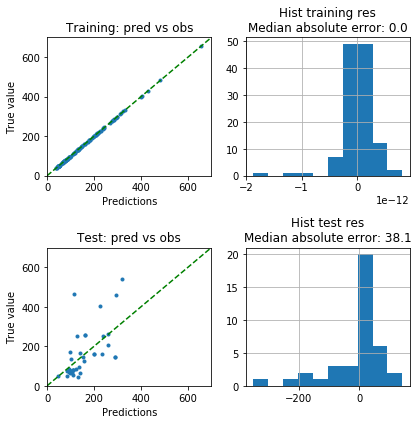

In [9]:
PLT.figure(figsize=(6,6))
PLT.subplot(221)
PLT.plot(meuse_train['lead_predict'], meuse_train['lead'], '.')
PLT.title('Training: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.plot([0,700], [0,700], 'g--')
PLT.ylim(0,700)
PLT.xlim(0,700)
PLT.subplot(222)
meuse_train['residual'].hist()
PLT.title('Hist training res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(meuse_train['residual']))))
PLT.subplot(223)
PLT.plot(meuse_test['lead_predict'], meuse_test['lead'], '.')
PLT.plot([0,700], [0,700], 'g--')
PLT.title('Test: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.ylim(0,700)
PLT.xlim(0,700)
PLT.subplot(224)
meuse_test['residual'].hist()
PLT.title('Hist test res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(meuse_test['residual']))))
PLT.tight_layout()

In [10]:
var_muese = VARIOGRAM(100, model=variogram_spherical)
var_muese.fit(gdf[['x', 'y']], gdf['lead'], fit_range=[0,1500])
ok_muese = kriging_ordinary(var_muese)
ok_muese.fit(gdf[['x', 'y']], gdf['lead'])

In [11]:
buffer = 1000 # [m]
cellsize = 50 # [m]
xmin = gdf['x'].min() - buffer
xmax = gdf['x'].max() + buffer
ymin = gdf['y'].min() - buffer
ymax = gdf['y'].max() + buffer
# * Create 2D extent and grid
## Grid is from top-left to bottom-right
X, Y = NP.meshgrid( NP.arange(xmin, xmax+cellsize, cellsize),
                    NP.arange(ymin, ymax+cellsize, cellsize))
## set prediction location is in the central of grid
xy = NP.concatenate(( X.flatten()[:, NP.newaxis] + cellsize/2,
                      Y.flatten()[:, NP.newaxis] - cellsize/2),
                      axis=1)
## Define variables
xbins = X.shape[1]
ybins = Y.shape[0]
transform = from_origin(X.min(), Y.max(), cellsize, cellsize) # Set raster left-top's coordinates

## Predict
print(">> Interpolating %d cells (%d, %d)...."%(len(xy), xbins, ybins))
lead_predict = ok_muese.predict(xy)
#lead_predict = ok_muese.predict(xy, radius=var_muese.range, n_neighbor=7)
#print(var_muese.range)

>> Interpolating 11543 cells (97, 119)....


In [12]:
z = lead_predict[0]
raster = RAST.open('./data/meuse_prediction.tif', 
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=z.dtype,
                    crs='epsg:28992',
                    transform=transform )
raster.write(NP.flip(z.reshape(ybins,xbins), 0), 1)
raster.close()

In [13]:
error = lead_predict[1]
raster = RAST.open('./data/meuse_prediction_error.tif', 
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=error.dtype,
                    crs='epsg:28992',
                    transform=transform )
raster.write(NP.flip(error.reshape(ybins,xbins), 0), 1)
raster.close()

## Data 2

In [14]:
df = PD.read_csv('./data/earthquaketw.csv')
df.head()

,event,datetime,lon,lat,depth,intensity,station_id,station_name,station_lon,station_lat,distance,az,pga_v,pga_ns,pga_ew,d,pga_max,pga
0,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,TWD,Xiulin,311007.912765,2.664013e+06,8.22,255.19,8.24,5.79,8.24,7455.018061,8.24,13.012275
1,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETM,Tongmen,299865.343998,2.651787e+06,11.26,17.81,27.06,53.78,53.78,10766.259718,53.78,80.726826
2,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,HWA,HualienCity,312072.754264,2.652942e+06,13.09,317.56,15.05,14.58,15.05,12030.634070,15.05,25.798864
3,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETL,Taroko,313002.380630,2.672882e+06,14.44,222.69,5.94,19.33,19.33,14365.702485,19.33,27.974656
4,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETLH,Xibao,298756.774779,2.678364e+06,16.64,164.09,6.89,8.04,8.04,17372.811019,8.04,13.294935


In [15]:
NP.random.seed(0)
test_idxes = NP.random.choice(a=df.index, size=int(NP.round(len(df)/4)))
train_idxes = NP.array(list(set(df.index).difference(set(test_idxes))))
tw_test = df.loc[test_idxes,:].copy()
tw_train = df.loc[train_idxes,:].copy()
print(len(tw_train), len(tw_test), len(df))

1699 548 2191


100%|██████████| 58/58 [00:00<00:00, 304.43it/s]


<Figure size 720x432 with 0 Axes>

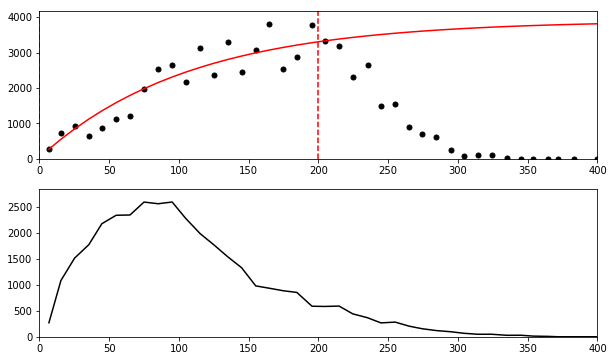

In [16]:
## Functions
def variogram_exponential(d, pars):
    """Exponential model, pars[3] = [psill, range, nugget]
                           d     
                      - ( --- )  
                          [1]    
    y = [0] * ( 1 - e^         ) + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return psill * (1. - NP.exp(-d/(prange))) + pnugget

## Train variogram
var_tw = VARIOGRAM(10, model=variogram_exponential)
events = TQDM(df['event'].unique())
for evt in events:
    event = tw_train.query('event == %d'%evt)
    if len(event) == 0 : continue
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    var_tw.calculate(X, y)
var_tw.update_fit(fit_range=[0,200])
PLT.figure(figsize=[10,6])
var_tw.plot()

In [17]:
ok_tw = kriging_ordinary(var_tw)

In [18]:
events = TQDM(df['event'].unique())
for evt in events:
    msk_train = tw_train['event'] == evt
    msk_test  = tw_test['event'] == evt
    
    X_train = tw_train.loc[msk_train, ['station_lon', 'station_lat']].values/1000
    X_test  = tw_test.loc[msk_test, ['station_lon', 'station_lat']].values/1000
    y_train = tw_train.loc[msk_train, 'pga'].values
    
    ## Load train data point
    if len(X_train) == 0: 
        continue
    else:
        ok_tw.fit(X_train, y_train)
        tw_train.loc[msk_train, 'pga_predict'] = ok_tw.predict(X_train)[0]
    
    if len(X_test) == 0:
        continue
    else:
        tw_test.loc[msk_test, 'pga_predict'] = ok_tw.predict(X_test)[0]

100%|██████████| 58/58 [00:00<00:00, 61.10it/s]


In [19]:
tw_train['residual'] = tw_train['pga_predict'] - tw_train['pga']
tw_test['residual'] = tw_test['pga_predict'] - tw_test['pga']

In [20]:
def r2(obs, exp):
    obs = NP.atleast_1d(obs)
    exp = NP.atleast_1d(obs)
    return 1 - sum((exp - obs)**2)/sum((obs - obs.mean())**2)
print('Train ', tw_train['residual'].mean(), tw_train['residual'].std(), r2(tw_train['pga'], tw_train['pga_predict']))
print('Test ', tw_test['residual'].mean(), tw_test['residual'].std(), r2(tw_test['pga'], tw_test['pga_predict']))

Train  2.1060911173436607e-16 1.2507458324395001e-14 1.0
Test  1.6124788131888712 16.88613060589681 1.0


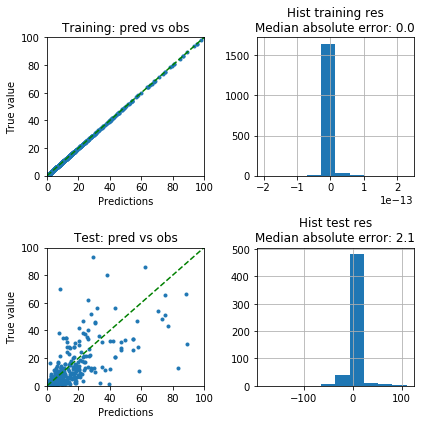

In [21]:
pga_limit = 100
PLT.figure(figsize=(6,6))
PLT.subplot(221)
PLT.plot(tw_train['pga_predict'], tw_train['pga'], '.')
PLT.title('Training: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.plot([0,pga_limit], [0,pga_limit], 'g--')
PLT.ylim(0,pga_limit)
PLT.xlim(0,pga_limit)
PLT.subplot(222)
tw_train['residual'].hist()
PLT.title('Hist training res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(tw_train['residual']))))
PLT.subplot(223)
PLT.plot(tw_test['pga_predict'], tw_test['pga'], '.')
PLT.plot([0,pga_limit], [0,pga_limit], 'g--')
PLT.title('Test: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.ylim(0,pga_limit)
PLT.xlim(0,pga_limit)
PLT.subplot(224)
tw_test['residual'].hist()
PLT.title('Hist test res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(tw_test['residual']))))
PLT.tight_layout()

In [22]:
events = TQDM(df['event'].unique())
for evt in events:
    event = df.query('event == %d'%evt)
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    var_tw.calculate(X, y)
var_tw.update_fit(fit_range=[0,200])

100%|██████████| 58/58 [00:00<00:00, 313.43it/s]


In [23]:
cellsize = 5000 # [m]
xmin = 145541
xmax = 355210
ymin = 2421543
ymax = 2800785
# * Create 2D extent and grid
## Grid is from top-left to bottom-right
X, Y = NP.meshgrid( NP.arange(xmin, xmax+cellsize, cellsize),
                    NP.arange(ymin, ymax+cellsize, cellsize))
## set prediction location is in the central of grid
xy = NP.concatenate(( X.flatten()[:, NP.newaxis] + cellsize/2,
                      Y.flatten()[:, NP.newaxis] - cellsize/2),
                      axis=1)
## Define variables
xbins = X.shape[1]
ybins = Y.shape[0]
transform = from_origin(X.min(), Y.max(), cellsize, cellsize) # Set raster left-top's coordinates
print(">> Interpolating %d cells (%d, %d)...."%(len(xy), xbins, ybins))

>> Interpolating 3311 cells (43, 77)....


In [24]:
## Predict
events = TQDM(df['event'].unique())
for evt in events:
    event = df.query('event == %d'%evt).reset_index(drop=True)
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    name = event['datetime'].values[0].split()[0]
    ok_tw.fit(X, y)
    prediction = ok_tw.predict(xy/1000., radius=var_tw.range)
    #raster = RAST.open('./data/pga_prediction_%d_%s.tif'%(evt, name), 
    raster = RAST.open('./data/pgaR_prediction_%d_%s.tif'%(evt, name), 
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=prediction[0].dtype,
                    crs='epsg:3826',
                    transform=transform )
    raster.write(NP.flip(prediction[0].reshape(ybins,xbins), 0), 1)
    raster.close()
    
    #raster = RAST.open('./data/pga_prediction_error_%d_%s.tif'%(evt,name),
    raster = RAST.open('./data/pgaR_prediction_error_%d_%s.tif'%(evt,name),                   
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=prediction[1].dtype,
                    crs='epsg:3826',
                    transform=transform )
    raster.write(NP.flip(prediction[1].reshape(ybins,xbins), 0), 1)
    raster.close()
    
    event['geom'] = event[['station_lon', 'station_lat']].apply(lambda x: Point(x), axis=1)
    event = GPD.GeoDataFrame(event[['event', 'depth', 'intensity', 'station_id', 'distance', 'az', 'pga_v', 'pga_ns', 'pga_ew', 'd', 'pga_max', 'pga', 'geom']], geometry='geom')
    event.crs={'init' :'epsg:3826'}
    event.to_file('./data/earthquaketw_%d_%s.shp'%(evt,name), driver='ESRI Shapefile', encoding = 'utf-8')

100%|██████████| 58/58 [00:19<00:00,  3.45it/s]
